In [ ]:
!git clone https://github.com/pkseniya/ReSuMe

Cloning into 'ReSuMe'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 98 (delta 51), reused 5 (delta 1), pack-reused 0
Receiving objects: 100% (98/98), 43.56 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
from ReSuMe.input_and_lif_3 import generator, LIF_network, get_W, raster_plot

In [ ]:
#All imports here
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from scipy.sparse import random as sparse_random
from scipy.sparse import csr_matrix

#1. Generate input and desired signals: S_in and S_d

In [ ]:
dt=1
tmax=400
nt=int(tmax/dt)+1
rate=50
t = np.linspace(0.0, tmax, nt)
N = 800 # total number of neurons
S_in = generator(1, dt, nt, rate).reshape(t.shape)

Text(0.5, 0, 't [ms]')

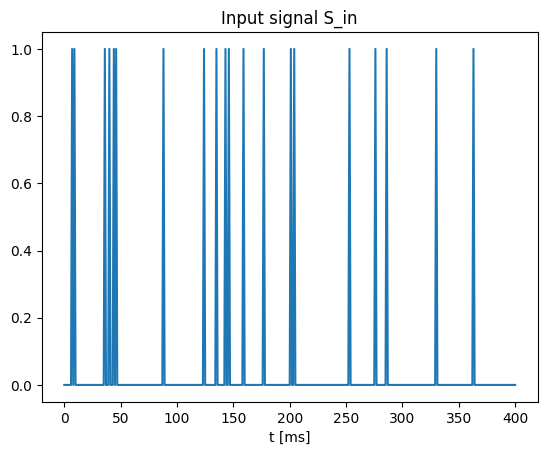

In [ ]:
plt.plot(t,S_in)
plt.title('Input signal S_in')
plt.xlabel('t [ms]')

In [ ]:
print(f'number of spikes in the input signal S_in : {S_in.sum()}')

number of spikes in the input signal S_in : 20


Text(0.5, 0, 't [ms]')

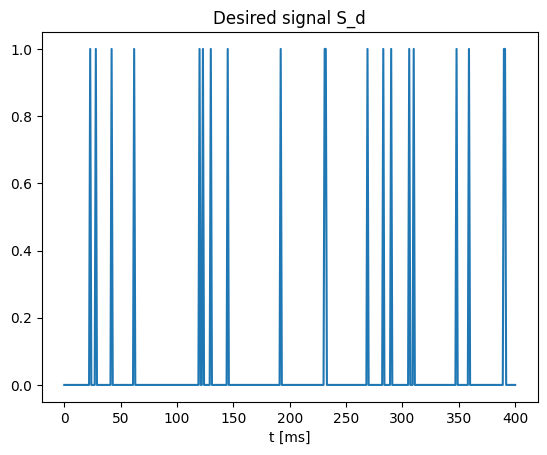

In [ ]:
S_d = generator(1, dt, nt, rate).reshape(t.shape)
plt.plot(t,S_d)
plt.title('Desired signal S_d')
plt.xlabel('t [ms]')

In [ ]:
print(f'number of spikes in the desired signal S_d : {S_d.sum()}')

number of spikes in the desired signal S_d : 20


#2. Get NMC state trace Sˆ_in(t) resulting from S_in(t)  

In [ ]:
neur_ei=np.ones(N) #array of excitatory/inhibitory neuron flags (neur_ei[i]=1 - neuron i is excitatory, neur_ei[i]=0 - neuron i is inhibitory)
N_in=int(0.2*N)
inh_inds=np.array(random.sample(range(0,800),N_in))
neur_ei[inh_inds]=0
ex_inds=np.where(neur_ei>0)

neur_ei=np.append(neur_ei, 1) #we append the input artificial neuron that "gave us S_in"

# LIF model parameters
p = {}
# membrane capacitance:
p['tau'] = 70. # (ms)
# membrane resistance:
p['R'] = 1 # (GOhm)
#p['R'] = 1e-3
# membrane potential threshold:
p['V_t'] = 20.   # (mV)
#p['V_t'] = -0.055 # (V)
# reversal potential of the leakage current
p['E_L'] = 13.5  # (mV)
# membrane reset voltage:
p['V_r'] = 13.5   # (mV)
#p['V_r'] = -0.062 # (V)
p['t_r_e'] = 3. # (ms)
p['t_r_i'] = 2. # (ms)

# injected current (nA)
I0 = 13.5
#I0 = 5e-13

C_ee=0.3
C_ei=0.2
C_ie=0.4
C_ii=0.1


# Weight = 0.1
Weight = 2e-9
W = get_W(N, C_ee, C_ei, C_ie, C_ii, neur_ei, Weight)

Stochastic_current_amplitude_ex=10.
Stochastic_current_amplitude_in=7.

V_full, spikes = LIF_network(N,dt,tmax,p,W,I0,S_in, neur_ei, Stochastic_current_amplitude_ex, Stochastic_current_amplitude_in)

100%|██████████| 400/400 [00:00<00:00, 777.93it/s]


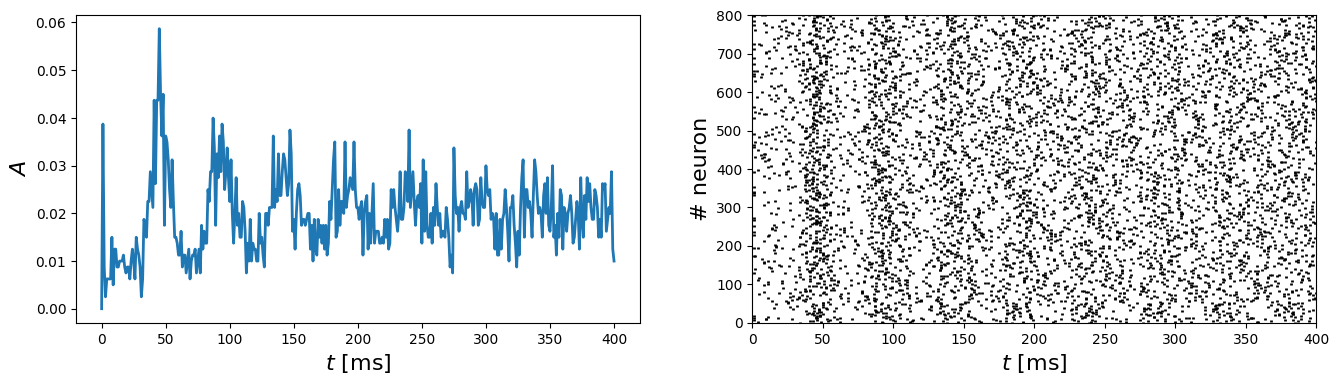

In [ ]:
raster_plot(spikes, t)

In [ ]:
spikes.shape

(401, 801)

In [ ]:
S_hat_in = spikes[:, :800]
S_hat_in.shape

(401, 800)

#3. Get the output S_l(t) before the training from one readout neuron

In [ ]:
def solve_LIF_model(nt, I0, V0, p, initial_spikes, W, N=800, D=5):
    """
    This function solves the differential equation
    that describes the LIF model for an injected current impulse I

    Args:
        dt (float): time step duration (ms)
        tmax (float): final time (ms)
        I0 (float): injected current amplitude (pA)
        V0 (float): voltage initial condition (mV)
        p (dict): parameters of the LIF model
        spikes (numpy array): binary spike train

    Returns:
        V, spikes: calculated membrane potential and binary spike train
    """

    # initialization
    #nt = int(tmax / dt) + 1  # number of time steps
    V = np.zeros(nt)

    # initial condition
    V[0] = V0

    tau = p['tau']  # (ms)
    count = 0

    spikes_new = np.zeros(nt)

    # Main loop for a numerical integration of the LIF model
    for k in range(nt - 1):
        I_ext = I0 + D * np.random.normal(size=(1, ))
        # calculate the synaptic current
        I_syn = (initial_spikes[k, :] @ W).reshape((-1, 1))
        IC_big = I_ext + I_syn
        IC_big = IC_big.flatten()

        if count <= 0:
            # keep in mind that I*R is in units of mV
            V[k + 1] = V[k] + dt / tau * (p['E_L'] - V[k] + p['R'] * IC_big[0])
            if V[k + 1] >= p['V_t']:
                V[k + 1] = p['V_r']
                spikes_new[k+1] += 1
                count = int(p['t_r_e'] / dt)
        else:
            V[k + 1] = p['V_r']
            count -= 1

    return V, spikes_new

In [ ]:
def step_LIF_model(I0, V_l_prev, p, initial_spikes, W, count, D=5.):


    # initial condition
    V = V_l_prev

    tau = p['tau']  # (ms)
    spikes_new = 0

    # Main loop for a numerical integration of the LIF model
    I_ext = I0
    #I_ext = I0 + D * np.random.randn()
        # calculate the synaptic current
    I_syn = (initial_spikes @ W).item()
    IC_big = I_ext + I_syn

    if count <= 0:
        # keep in mind that I*R is in units of mV
        V = V + dt / tau * (p['E_L'] - V + p['R'] * IC_big)
        if V >= p['V_t']:
            V = p['V_r']
            spikes_new += 1
            count = int(p['t_r_e'] / dt)
    else:
        V = p['V_r']
        count -= 1

    return V, spikes_new, count

In [ ]:
# LIF model parameters
p = {
    'tau': 10.,    # membrane capacitance (ms)
    'R': 1,        # membrane resistance (GOhm)
    'V_t': 20.,    # membrane potential threshold (mV)
    'E_L': 13.5,   # reversal potential of the leakage current (mV)
    'V_r': 10.5,   # membrane reset voltage (mV)
    't_r_e': 3.,   # excitatory membrane reset time (ms)
    't_r_i': 2.    # inhibitory membrane reset time (ms)
}


I0 = 13.5
V0 = p['E_L']
dt = 1
tmax = 400

np.random.seed(10)
W_new = np.random.binomial(1, 0.5, size=(800, 1)) ##make it sparse!!
# density = 0.6  # Density of the non-zero elements
# W_new = sparse_random(800, 1, density=density, format='csr')

In [ ]:
V_l, S_l = solve_LIF_model(401, I0, V0, p, S_hat_in, W_new)

Text(0.5, 0, 't [ms]')

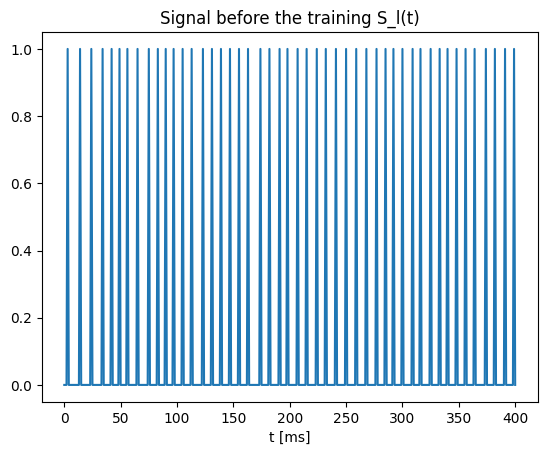

In [ ]:
plt.plot(t,S_l)
plt.title('Signal before the training S_l(t)')
plt.xlabel('t [ms]')

In [ ]:
print(f'number of spikes in the signal S_l : {S_l.sum()}')

number of spikes in the signal S_l : 48.0


#4. Initialization of functions for calculating perfomance metrics

In [ ]:
def extract_tf(S):
    return np.where(S == 1)[0]

# Performance index
'''here the main function is Pm with args
   tfl_l, tfd_l, t_l: t_l is list/array
   of every time step from zero 400 ms;
   tfl_l and tfl_d are lists/arrays of
   particular time steps at which
   there is a spike in spike train of
   output before the training S^l(t) and
   desired output after training S^d(t)
'''
def Hevi_func(t, tf):
  if t < tf:
    return 0
  else:
    return 1

def exp(t,tf):
  tau = 1
  return np.exp((-t+tf)/tau)

def L_S(t_l, tf_l):
  L_S = []
  for t in t_l:
    sum = 0
    for tf in tf_l:
      H = Hevi_func(t, tf)
      sum += exp(t,tf) * H
    L_S.append(sum)
  return L_S

def Pm(Sl, Sd, t_l):
  tfl_l = extract_tf(Sl)
  tfd_l = extract_tf(Sd)
  L_Sl = L_S(t_l, tfl_l)
  L_Sd = L_S(t_l, tfd_l)

  L_Sd_arr = np.array(L_Sd)
  L_Sl_arr = np.array(L_Sl)


  abs_diff = np.abs(L_Sd_arr - L_Sl_arr)

  return np.trapz(abs_diff)

#Precision
'''in this function firstly we calculate
   minimal inter-spike interval in S^d(t)
   to define parameter r. Then check two
   conditions of approximation with this
   parameter
'''
def precision_calc(Sl_hat, Sd):
  tfl_l_hat = extract_tf(Sl_hat)
  tfd_l = extract_tf(Sd)
  min = 500
  for i in range(tfd_l.shape[0]-1):
    if np.abs(tfd_l[i] - tfd_l[i+1]) < min:
      min = np.abs(tfd_l[i] - tfd_l[i+1])

  r = round(min/2, 2)

  if tfl_l_hat.shape[0] == tfd_l.shape[0]:
    for tfd in tfd_l:
      tfd_array = np.ones_like(tfl_l_hat) * tfd
      abs_diff = np.abs(tfd_array - tfl_l_hat)
      if np.count_nonzero(abs_diff <= r) != 1:
        return f'S^l_hat(t) does not approximate S^d(t) with the precision r = {r}'
      else:
        return f'S^l_hat(t) approximates S^d(t) with the precision r = {r}'

#Spike-shift error e(t)
'''in this function we calculate time
   difference between td and the nearest
   spike in tl_f. Finally this function
   returns a list of pairs (td,(f),∆t(f))
'''

def error(Sl_hat, Sd):
  tfl_l_hat = extract_tf(Sl_hat)
  tfd_l = extract_tf(Sd)
  e = []
  for td in tfd_l:
    nearest_spike_time = min(tfl_l_hat, key=lambda x: abs(x - td))
    delta_t = abs(td - nearest_spike_time)
    e.append((td, delta_t))

  return e


#5. Perfom 100 learning sessions to train signal S_l(t)

In [ ]:
#from ReSuMe.perfomance_metrics import precision_calc, error, Pm
import numpy as np

class Learner:
    def __init__(self, inh_inds, A_d=1, A_l=1, tau_d=1, tau_l=1, a_d=0.1, a_l=-0.1): # A_d=0.8, A_l=0.25, tau_d=0.7, tau_l=1, a_d=0.5, a_l=-0.5
        self.inh_inds = inh_inds
        self.A_d = A_d
        self.A_l = A_l
        self.tau_d = tau_d
        self.tau_l = tau_l
        self.a_d = a_d
        self.a_l = a_l

    def W_d(self, s_d):
        return np.where(s_d > 0, self.A_d * np.exp(-s_d / self.tau_d), 0)

    def W_l(self, s_l):
        return np.where(s_l > 0, -self.A_l * np.exp(-s_l / self.tau_l), 0)

    def update(self, t, S_l_i, S_d_i, S_in, dt=1):
        # S_l [num_ts], S_d [num_ts], S_in [num_neurons, num_ts]

        dws = []
        num_neurons, num_ts = S_in.shape

        times = np.repeat(np.arange(401).reshape(1, -1), num_neurons, axis=0)

        dw_d = np.where(S_in, self.W_d(-times + t), 0).sum(1)
        dw_l = np.where(S_in, self.W_l(-times + t), 0).sum(1)

        mul = np.ones((num_neurons, ))
        mul[self.inh_inds] = -1

        dw = mul * (S_d_i * (self.a_d + dw_d) + S_l_i * (self.a_l + dw_l))

        return dw.reshape(-1, 1)

learner = Learner(inh_inds)


W_new = W_new.astype(float)

learning_steps = 100
e = []
P_m = []

#tfs = extract_tf([1] * 401)

lr = 0.125 # LEARNING RATE
S_l_pred_curr = np.zeros((401))
S_suc = []
for step in tqdm(range(learning_steps)):
    V_l_prev = V0
    count_prev = 0

    for i in range(401):
        tf_l = extract_tf(S_l_pred_curr)
        tf_d = extract_tf(S_d)

        if i in tf_l or i in tf_d:
            dw = learner.update(i, S_l_pred_curr[i], S_d[i], S_hat_in.T)
        else:
            dw = np.zeros_like(W_new)

        W_new += lr * dw

        V_l, S_l_pred, count = step_LIF_model(I0, V_l_prev, p, S_hat_in[i], W_new, count_prev)
        V_l_prev = V_l
        count_prev = count
        S_l_pred_curr[i] = S_l_pred
    print(S_l_pred_curr.sum())

    P_m.append(Pm(S_l_pred_curr, S_d, t)) # tfs - массив с временами
    e.append(error(S_l_pred_curr, S_d))

    if (precision_calc(S_l_pred_curr, S_d)) is not None and ('not' not in precision_calc(S_l_pred_curr, S_d)):
      print(precision_calc(S_l_pred_curr, S_d))
      print(S_l_pred_curr.sum(), S_l_pred_curr)
      #S_suc.append(S_l_pred_curr)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

51.0


  0%|          | 0/401 [00:00<?, ?it/s]

50.0


  0%|          | 0/401 [00:00<?, ?it/s]

43.0


  0%|          | 0/401 [00:00<?, ?it/s]

36.0


  0%|          | 0/401 [00:00<?, ?it/s]

31.0


  0%|          | 0/401 [00:00<?, ?it/s]

26.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0
S^l_hat(t) approximates S^d(t) with the precision r = 0.5
20.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

18.0


  0%|          | 0/401 [00:00<?, ?it/s]

19.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

21.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


  0%|          | 0/401 [00:00<?, ?it/s]

20.0


#6. Plot signal S_l(t) after training

Text(0.5, 0, 't [ms]')

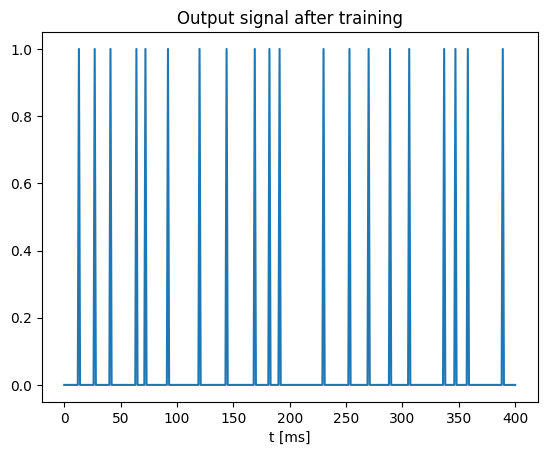

In [ ]:
t = np.linspace(0.0, 400, nt)
plt.plot(t,S_l_pred_curr)
plt.title('Output signal after training')
plt.xlabel('t [ms]')

In [ ]:
S_l_pred_curr.sum()

20.0

In [ ]:
S_l_pred_curr2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

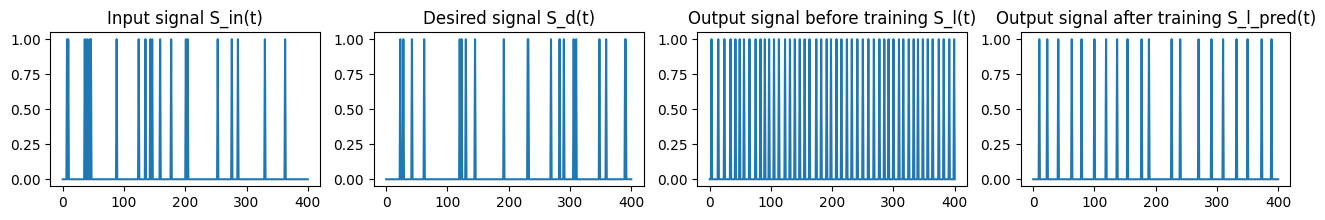

number of spikes in the input signal S_in : 20
number of spikes in the desired signal S_d : 20
number of spikes in the signal S_l : 48.0
number of spikes in the output signal after training : 20


In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 2))

axs[0].plot(t, S_in)
axs[0].set_title('Input signal S_in(t)')

axs[1].plot(t, S_d)
axs[1].set_title('Desired signal S_d(t)')

axs[2].plot(t, S_l)
axs[2].set_title('Output signal before training S_l(t)')

axs[3].plot(t, S_l_pred_curr2)
axs[3].set_title('Output signal after training S_l_pred(t)')


plt.savefig('res.png')
plt.show()

print(f'number of spikes in the input signal S_in : {S_in.sum()}')
print(f'number of spikes in the desired signal S_d : {S_d.sum()}')
print(f'number of spikes in the signal S_l : {S_l.sum()}')
print(f'number of spikes in the output signal after training : {S_l_pred_curr2.sum()}')

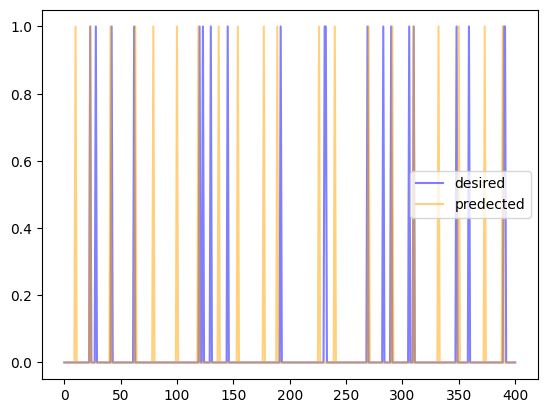

In [ ]:
plt.plot(t, S_d, color='blue', alpha=0.5, label='desired')
plt.plot(t, S_l_pred_curr2, color='orange', alpha=0.5, label='predected')
plt.legend()
plt.savefig('diff.png')
plt.show()

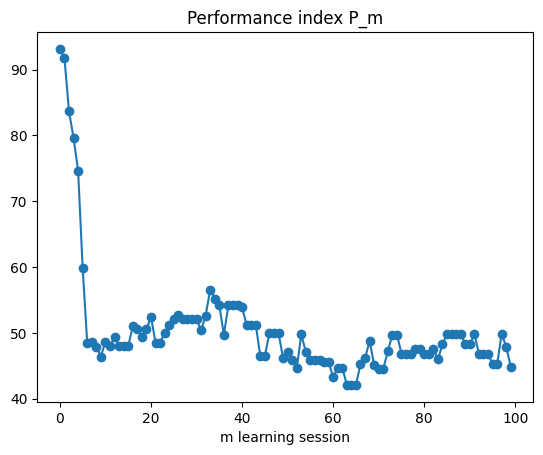

In [ ]:
m = np.arange(100) + 1
plt.plot(P_m, marker = 'o')
plt.title('Performance index P_m')
plt.xlabel('m learning session')
plt.savefig('pm.png')

//пока не запускали эту функцию в коде

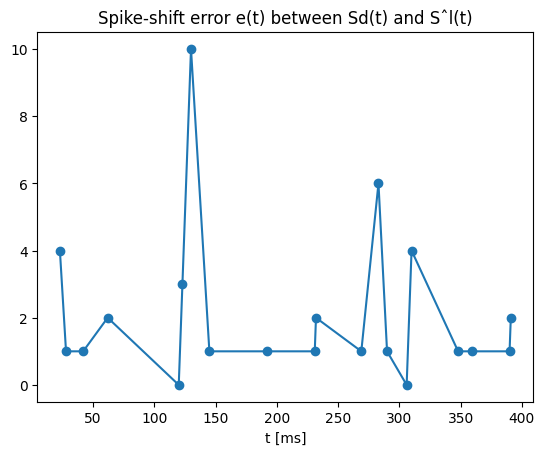

In [ ]:
#choosing errors on the last learning session e[-1]

t_d = [pair[0] for pair in e[-1]] #time moments of spikes in the desired signal S_d(t)
error = [pair[1] for pair in e[-1]] #differences between time moments of spikes in the desired signal S_d(t) and the nearest time moments
                                    #of spikes in the output signal after training

plt.plot(t_d, error, marker = 'o')
plt.title('Spike-shift error e(t) between Sd(t) and Sˆl(t)')
plt.xlabel('t [ms]')
plt.savefig('err.png')